In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi
import swarms
import pread as pds

In [2]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [3]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
data = pds.Pread('data', 'Z002', 'pltlum_M318Z002.csv') 

In [4]:
Mmoon = 7.35e22
Mjup = 1.898e27
Rjup = 7.1492e7
AU = 1.496e11
Mearth = 5.972e24
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26

In [5]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_sampler(mean=2., std=1.):
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    return Mstar, Lstar, Tstar, dpl

def distance_sampler(mean=30., std=10., survey=None):
    if survey == "GPI":
        mean = 60.15
    elif survey == "SPHERE":
        mean = 26.31
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)*pc
    return s
    
    
def draw_planet():
    Mmin = 15 # Mearth (Nep)
    Mmax = 13*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 0.5
    Npts = 1000
    alpha = -0.86
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None, None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = 10# AU
        amax = 200 # AU
        a = loguniform(amin, amax)
        return a*AU, ms[idx]*Mearth 
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler():
    y = uniform(0, 1)
    return inverse_cdf(y)

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

In [6]:
N = 500

Mstar_list = np.zeros(N)
Lstar_list = np.zeros(N)
Tstar_list = np.zeros(N)
s_type_list = np.zeros(N)
d_list = np.zeros(N)
d_list2 = np.zeros(N)
a_pl_list = np.zeros(N)
Mpl_list = np.zeros(N)
age_list = np.zeros(N)

for i in range(N):
    Mstar, Lstar, Tstar, dpl = star_sampler()
    Mstar_list[i] = Mstar; Lstar_list[i] = Lstar; Tstar_list[i] = Tstar; #s_type_list[i] = s_type
    #d_list[i] = dpl
    d_list[i] = distance_sampler(survey="GPI")
    d_list2[i] = distance_sampler(survey="SPHERE")
    a_pl, Mpl = draw_planet()
    a_pl_list[i] = a_pl; Mpl_list[i] = Mpl
    age_list[i] = age_sampler()*1e6

Text(0.5,1,'d_pl Sampled for Mtot=1')

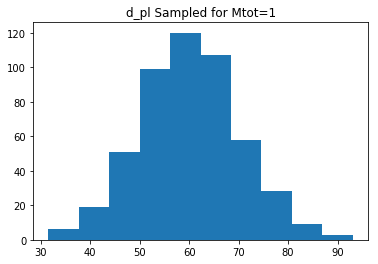

In [7]:
fig, ax = plt.subplots()
ax.hist(d_list/pc)
ax.set_title("d_pl Sampled for Mtot=1")
#ax.hist(d_list2/pc)

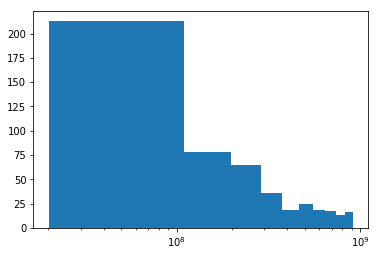

In [8]:
domain = np.logspace(1, 3, 500)
f = cdf(domain)
fig, ax = plt.subplots()
#ax.plot(domain, f)
ax.hist(age_list)
#ax.plot(20, 0, 'ro')
#ax.plot(135, 0.5, 'ro')
#ax.plot(620, 0.9, 'ro')
ax.set_xscale('log')

In [9]:
def sample(Mstar, Lstar, Tstar, dpl, apl, Mpl, age):
    if apl == None:
        return None, None, None, None
    
    Dc = loguniform(1e5, 1e6) # m
    Mtot = 1.*Mearth#loguniform(0.2, 2)*Mearth#loguniform(1e-4, 1)*Mearth
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.5) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4/np.pi
    alpha= 1.2
    swarm = swarms.CollSwarm(Mtot, Dt, Dmax, Lstar, Mstar, Mpl, apl, R_pl=None, eta=eta, Nstr=Nstr, d_pl=dpl,
                            rho=rho, fQ=fQ, f_vrel=f_vrel, correction=True, alpha=alpha, Dmin_min=1.25)

    swarm.updateSwarm(age)
    swarm_contrast = contrast_scat(swarm.computeAtot(), g, Q, apl)
    Qd = swarm.computeQd(swarm.Dc)
    part1 = (Mstar/1.989e30)**0.33 * f_vrel**0.55
    part2 = (Mpl/5.972e24)**0.06 * Qd**0.15 * eta
    part3 = age * (Mtot/5.972e24) / (rho * (swarm.Dc/1000)) 

    a_opt = 50 * part1 / part2 * part3**0.24 
    
    lamb = 1.65e-6
    B_nu = swarm.computeBmu(np.array([lamb]), Tstar)
    F_star = Fstar(Lstar, B_nu, Tstar, apl)
    
    # Planet Emissions
    index = data.find_time_index(age)
    if (index > -1):
        T_plt = lum_to_temp(data.lumin[index], data.radii[index])
        B_nu_plt = swarm.computeBmu(np.array([lamb]), T_plt)
        F_plt = Fstar(data.lumin[index], B_nu_plt, T_plt, apl)
        F_scat = Fscat(F_star, data.radii[index], g, Q, apl)
        #F_scat = contrast_scat(pi*data.radii[index]**2, g, Q, apl)
    else:
        return None, None, None, None
    
    return swarm_contrast, F_plt / F_star, F_scat / F_star, a_opt

In [10]:
CR_swarm_list = np.zeros(N); CR_plt_thermal = np.zeros(N); CR_plt_scat = np.zeros(N); a_opt_list = np.zeros(N)
for i in range(N):
    CR_swarm_list[i], CR_plt_thermal[i], CR_plt_scat[i], a_opt_list[i] = sample(Mstar_list[i], Lstar_list[i], Tstar_list[i], 
                                                                 d_list[i], a_pl_list[i], Mpl_list[i], age_list[i])
    d_list[i] = d_list[i] / pc
    a_pl_list[i] = a_pl_list[i] / AU

c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


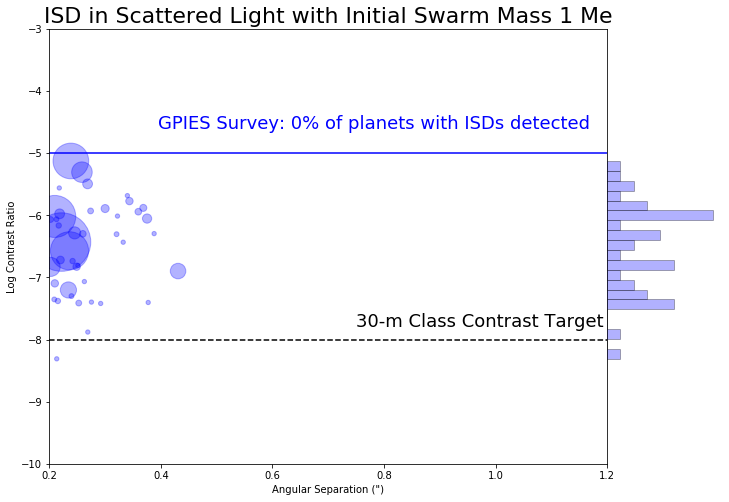

In [11]:
mask = (~np.isnan(CR_swarm_list)) & (a_pl_list/d_list > 0.2) & (a_pl_list/d_list < 1.2)
mask2 = (~np.isnan(CR_plt_thermal)) & (a_pl_list/d_list > 0.2) & (a_pl_list/d_list < 1.2)
cm = plt.cm.get_cmap('RdYlBu')

contrast = np.ones(1000)*1.e-5
contrastsep = np.linspace(0, 1.2, 1000)

sep = a_pl_list[mask]/d_list[mask]
sep2 = a_pl_list[mask2]/d_list[mask2]
logCR = np.log10(CR_swarm_list[mask])
logCR2 = np.log10(CR_plt_thermal[mask2])
Mpltcut = Mpl_list[mask]

idxs = np.searchsorted(contrastsep, sep)
detectable = np.log10(np.array(contrast)[idxs]) < logCR

#print(CR_plt_thermal)

fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
#axarr[0].scatter(sep2[detectable2], logCR2[detectable2], c='r', s=400*Mplt2cut/Mearth/318)
#axarr[0].scatter(sep2[~detectable2], logCR2[~detectable2], c='r', s=400*Mplt2cut/Mearth/318, alpha=0.3)
#axarr[0].scatter(sep2, logCR2, c='r', s=400*Mpltcut/Mearth/318, alpha=0.3)
axarr[0].scatter(sep, logCR, c='b', s=400*Mpltcut/Mearth/318, alpha=0.3)
axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-10, -3])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].set_title('ISD in Scattered Light with Initial Swarm Mass 1 Me', fontsize=22)
axarr[0].text(0.395, -4.6, "GPIES Survey: {0:.0f}% of planets with ISDs detected".format(detectable.sum()/len(sep)*100), color='b', fontsize=18)
axarr[0].text(0.75, -7.8, "30-m Class Contrast Target", color='k', fontsize=18)


plt.subplots_adjust(wspace=0)
axarr[1].set_axis_off()

vals, bins, patches = axarr[1].hist(np.log10(CR_swarm_list[mask]), orientation='horizontal', bins=20, facecolor='b', ec='k', alpha=0.3)
#vals, bins, patches = axarr[1].hist(np.log10(CR_plt_thermal[mask]), orientation='horizontal', bins=20, facecolor='r', ec='k', alpha=0.3)

c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


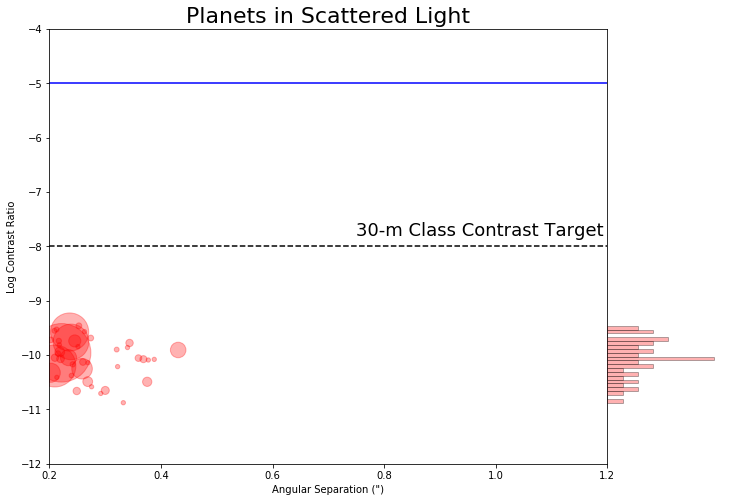

In [12]:
mask3 = (~np.isnan(CR_plt_scat)) & (a_pl_list/d_list > 0.2) & (a_pl_list/d_list < 1.2)

sep3 = a_pl_list[mask3]/d_list[mask3]
logCR3 = np.log10(CR_plt_scat[mask3])

fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
axarr[0].scatter(sep3, logCR3, c='r', s=400*Mpltcut/Mearth/318, alpha=0.3)
axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-12, -4])
axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].set_title('Planets in Scattered Light', fontsize=22)
axarr[0].text(0.75, -7.8, "30-m Class Contrast Target", color='k', fontsize=18)


plt.subplots_adjust(wspace=0)
axarr[1].set_axis_off()

vals, bins, patches = axarr[1].hist(np.log10(CR_plt_scat[mask3]), orientation='horizontal', bins=20, facecolor='r', ec='k', alpha=0.3)

In [13]:
from math import isnan
import scipy.stats as st
import matplotlib
from fitting import best_fit_distribution, make_pdf

Text(0.5,1,'Initial ISD Mass at $1 M_{\\oplus}$')

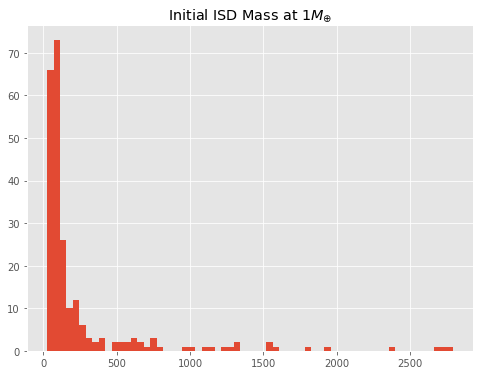

In [14]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.style.use('ggplot')

a_opt_clean = []
for i in range(len(a_opt_list)):
    if not isnan(a_opt_list[i]):
        a_opt_clean.append(a_opt_list[i]/0.7)

plt.figure()
n, bins, patches = plt.hist(a_opt_clean, bins='auto')
plt.title(r"Initial ISD Mass at $1 M_{\oplus}$")

In [15]:
best_fit_name, best_fit_params = best_fit_distribution(a_opt_clean, 200)
print(best_fit_name)
best_dist = getattr(st, best_fit_name)
pdf = make_pdf(best_dist, best_fit_params)

alpha


Text(0.5,1,"Initial ISD Mass at 1 Me   Mid-point GPI at 0.7''  Max: 5.336e+01 pc")

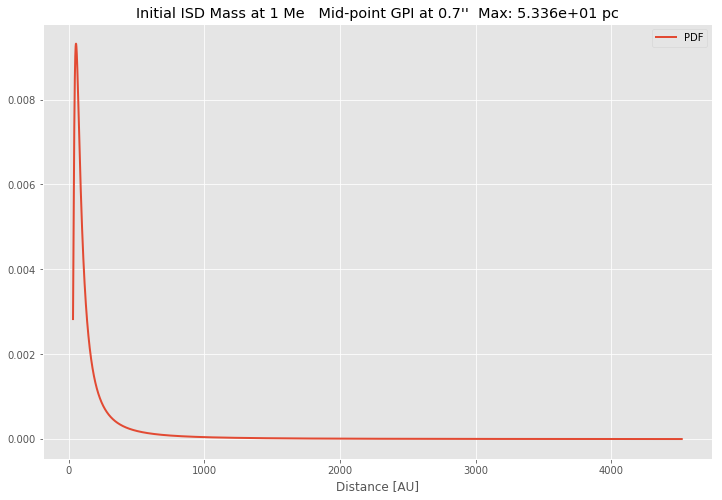

In [16]:
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
ax.set_xlabel("Distance [AU]")
#ax.set_xlabel("Angular Separation (\")")
#ax.set_title("Distance set at 25pc")
ax.set_title("Initial ISD Mass at 1 Me   Mid-point GPI at 0.7''  Max: {0:.3e}".format(pdf.idxmax()) + " pc")